In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import string
import time
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import glob

In [2]:
imgres = 64

# Setup model
class AutoencoderCNN(Model):
    def __init__(self, imgres, d, k):
        """
        Parameters
        ----------
        imgres: int
            Resolution of each grayscale image
        d: int
            Dimension of the embedding
        k: int
            Kernel size at each layer
        """
        super(AutoencoderCNN, self).__init__()
        self.imgres = imgres
        self.d = d
        self.k = k
        self.encoder = Sequential([
            layers.Input(shape=(imgres, imgres, 1)),
            layers.Conv2D(32, (k, k), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (k, k), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(128, (k, k), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(d, activation='relu')
        ])
        
        self.decoder = Sequential([
            layers.Input(shape=(d,)),
            layers.Dense(2*imgres**2),
            layers.Reshape((imgres//8, imgres//8, 128)),
            layers.Conv2DTranspose(128, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(64, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(32, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(1, kernel_size=(k, k), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AutoencoderCNN(imgres=imgres, d=128, k=3)
print(autoencoder.encoder.summary())
print(autoencoder.decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [3]:
class PlotterCallback(tf.keras.callbacks.Callback):
    def __init__(self, n=10):
        self.epoch = 0
        self.n = n
        self.plot_imgs = datagen.flow_from_directory('cats_{}x{}_grayscale/test'.format(imgres, imgres),
        class_mode="input", batch_size=n, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")
        self.X = self.plot_imgs.next()[0]
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        X = self.X
        encoded_imgs = autoencoder.encoder(X).numpy()
        print(encoded_imgs.shape)
        decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
        plt.figure(figsize=(20, 5))
        n = self.n
        for i in range(n):
            # display original
            plt.subplot(3, n, i + 1)
            plt.imshow(X[i, :, :, 0], cmap='gray')
            plt.title("original")
            plt.axis("off")

            # display reconstruction
            plt.subplot(3, n, n+i+1)
            plt.imshow(decoded_imgs[i], cmap='gray')
            plt.title("reconstructed")
            plt.axis("off")

            # display difference
            plt.subplot(3, n, 2*n+i+1)
            plt.imshow(X[i, :, :, :] - decoded_imgs[i], cmap='gray')
            plt.title("Difference")
            plt.axis("off")
        self.epoch += 1
        plt.savefig("Epoch{}.png".format(self.epoch), bbox_inches='tight')
        plt.show()

In [4]:
datagen = ImageDataGenerator(rescale=1/255)
train_it = datagen.flow_from_directory('cats_{}x{}_grayscale/train'.format(imgres, imgres),
        class_mode="input", batch_size=64, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")
test_it = datagen.flow_from_directory('cats_{}x{}_grayscale/test'.format(imgres, imgres),
        class_mode="input", batch_size=64, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")

Found 11810 images belonging to 1 classes.
Found 3937 images belonging to 1 classes.


Found 3937 images belonging to 1 classes.
Epoch 1/10
185/185 [==============================] - ETA: 0s - loss: 0.0277End epoch 0 of training; got log keys: ['loss', 'val_loss']
(10, 128)


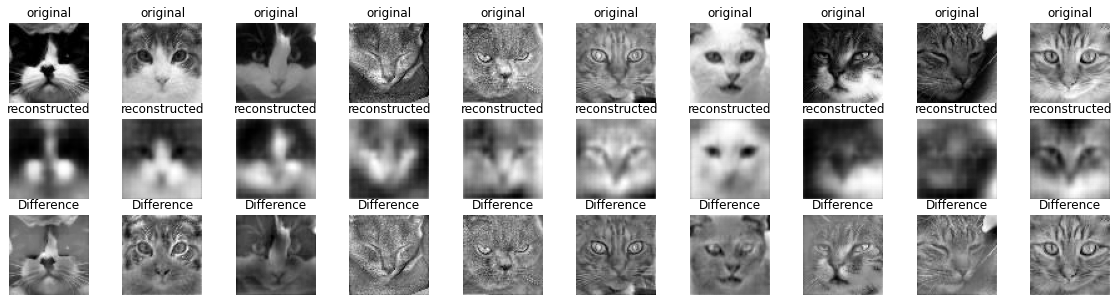

185/185 [==============================] - 83s 449ms/step - loss: 0.0277 - val_loss: 0.0150
Epoch 2/10
185/185 [==============================] - ETA: 0s - loss: 0.0138End epoch 1 of training; got log keys: ['loss', 'val_loss']
(10, 128)


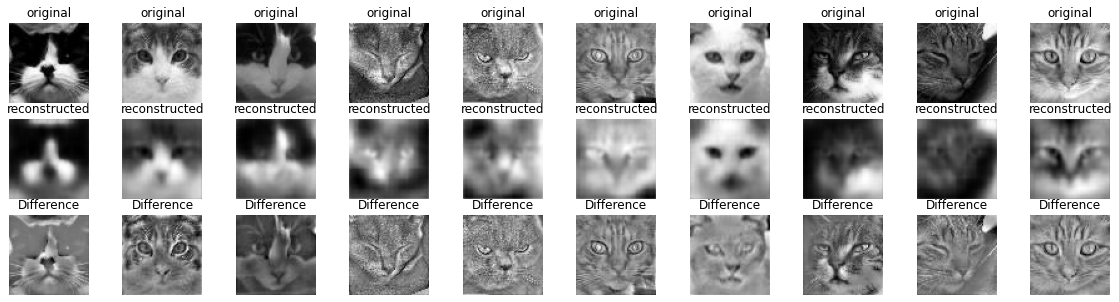

185/185 [==============================] - 79s 427ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 3/10
185/185 [==============================] - ETA: 0s - loss: 0.0116End epoch 2 of training; got log keys: ['loss', 'val_loss']
(10, 128)


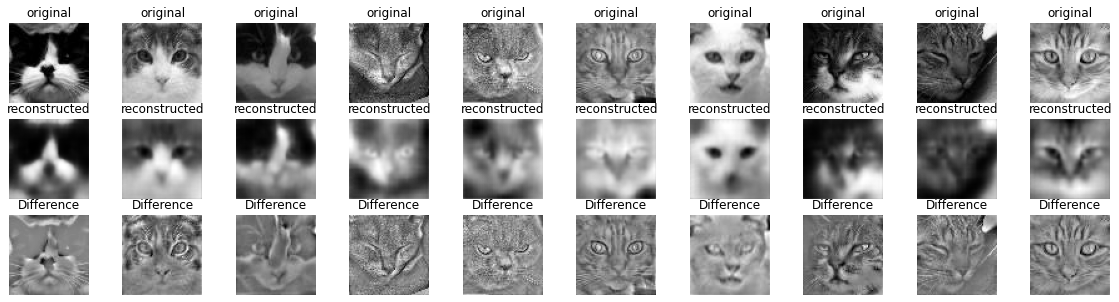

185/185 [==============================] - 87s 473ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 4/10
185/185 [==============================] - ETA: 0s - loss: 0.0105End epoch 3 of training; got log keys: ['loss', 'val_loss']
(10, 128)


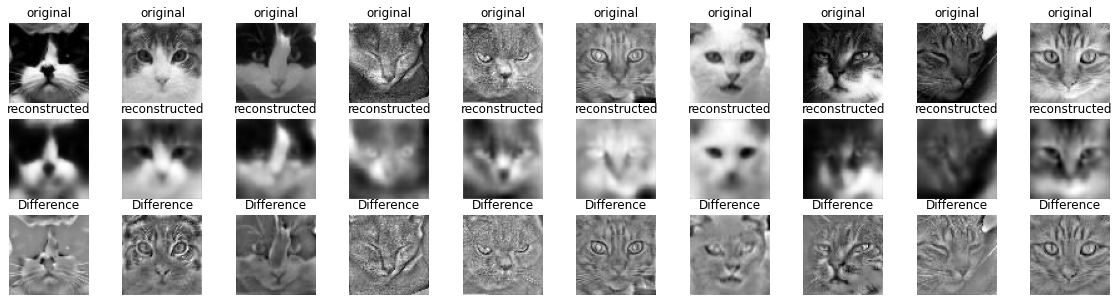

185/185 [==============================] - 76s 411ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 5/10
185/185 [==============================] - ETA: 0s - loss: 0.0098End epoch 4 of training; got log keys: ['loss', 'val_loss']
(10, 128)


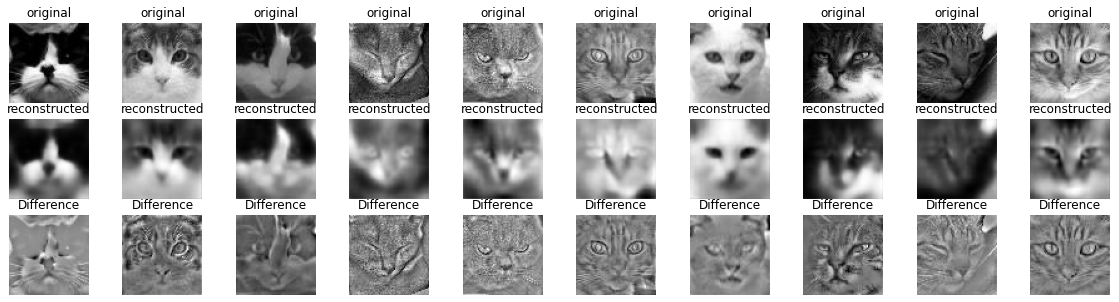

185/185 [==============================] - 81s 435ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 6/10
185/185 [==============================] - ETA: 0s - loss: 0.0093End epoch 5 of training; got log keys: ['loss', 'val_loss']
(10, 128)


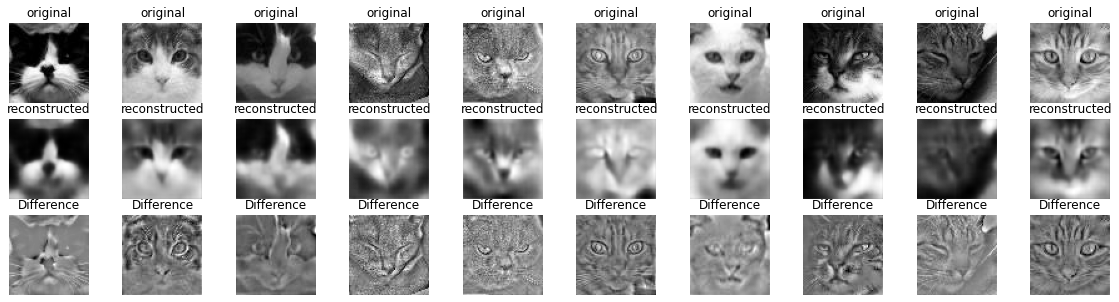

185/185 [==============================] - 88s 474ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/10
185/185 [==============================] - ETA: 0s - loss: 0.0090End epoch 6 of training; got log keys: ['loss', 'val_loss']
(10, 128)


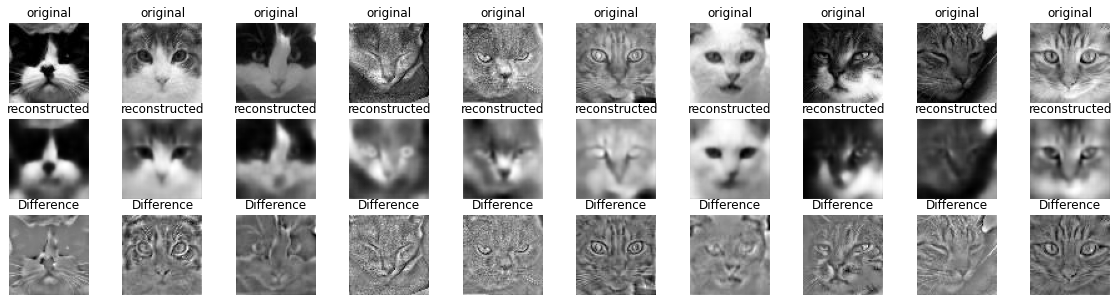

185/185 [==============================] - 86s 464ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 8/10
185/185 [==============================] - ETA: 0s - loss: 0.0087End epoch 7 of training; got log keys: ['loss', 'val_loss']
(10, 128)


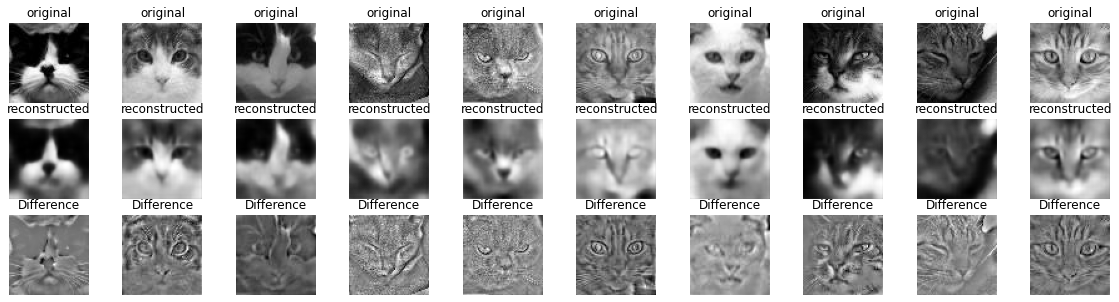

185/185 [==============================] - 78s 421ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 9/10
185/185 [==============================] - ETA: 0s - loss: 0.0084End epoch 8 of training; got log keys: ['loss', 'val_loss']
(10, 128)


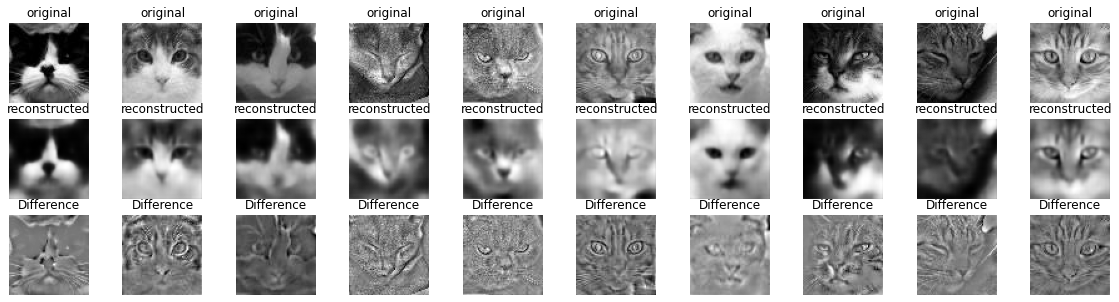

185/185 [==============================] - 81s 436ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 10/10
185/185 [==============================] - ETA: 0s - loss: 0.0082End epoch 9 of training; got log keys: ['loss', 'val_loss']
(10, 128)


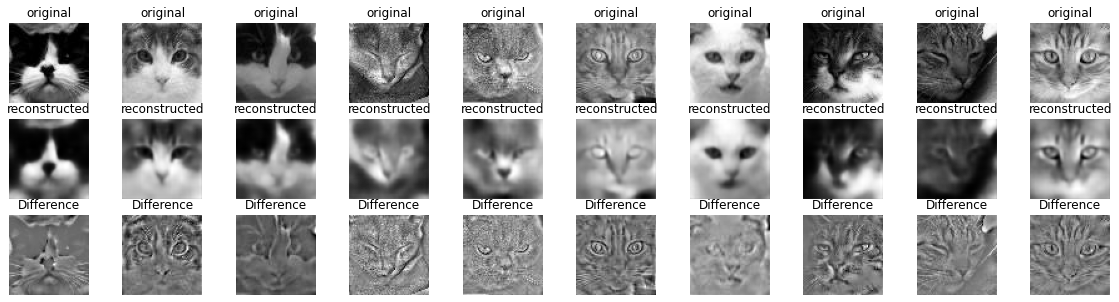

185/185 [==============================] - 83s 448ms/step - loss: 0.0082 - val_loss: 0.0078


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(train_it, 
                           steps_per_epoch=len(train_it),
                           validation_data=test_it,
                           validation_steps=len(test_it),
                           epochs=10,
                           verbose=1,
                           callbacks=[PlotterCallback()])

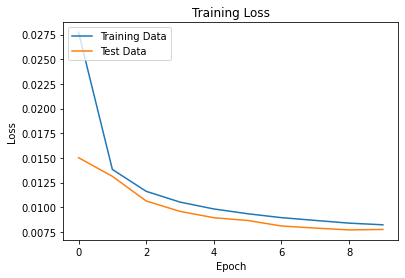

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')

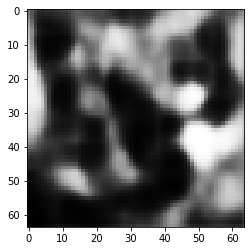

In [9]:
x = autoencoder.decoder(np.random.randn(1, 128)).numpy()
plt.imshow(x[0, :, :, 0], cmap='gray')

In [8]:
autoencoder.save_weights("models/catautoencoder")